In [1]:
!pip install rdkit
!pip install smilespe
!pip install selfies

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 34.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pickle
import pandas as pd

import selfies as sf
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from sklearn.preprocessing import StandardScaler

In [3]:
# Generate molecules from an initial character
unique_chars = ['!', 'E', '[#Branch1]', '[#Branch2]', '[#C]', '[#N]', '[=Branch1]', '[=Branch2]', '[=C]', '[=N]', '[=O]', '[=Ring1]', '[=Ring2]', '[=S]', '[Br]', '[Branch1]', '[Branch2]', '[C]', '[Cl]', '[F]', '[H]', '[NH1]', '[N]', '[O]', '[P]', '[Ring1]', '[Ring2]', '[S]']
char_to_int = dict((c,i) for i,c in enumerate(unique_chars))
int_to_char = dict((i,c) for i,c in enumerate(unique_chars))

generative_model = load_model('generative_model_selfies_best.h5')

def generate_mol(start_char):
  # Probability array
  prob_array = []

  # Encode the start character
  char_vec = np.zeros((1,1,len(unique_chars)))
  char_vec[0,0,char_to_int[start_char]] = 1
  smi_string = start_char

  # Predict the first character
  predict = generative_model(char_vec) # Generates probabilities of next char
  next_char = int_to_char[np.random.choice(np.arange(0,len(char_to_int)), p=predict.numpy().flatten())]
  prob_array.append(predict)
  smi_string += next_char # append the generated character to the SMILES string
  next_char_encoded = np.zeros((1,1,len(unique_chars)))
  next_char_encoded[0,0,char_to_int[next_char]] = 1 # Encode the predicted char
  char_vec = np.append(char_vec, next_char_encoded, axis=1) # Append it to starting char

  # Repeat the above prediction tasks until we hit the ending token 'E'
  while next_char != 'E':
    prediction = generative_model(np.expand_dims(char_vec[:,-1,:], axis = 1))
    next_char = int_to_char[np.random.choice(np.arange(0,len(char_to_int)), size=None, replace=True, p=prediction.numpy().flatten())]
    prob_array.append(prediction)

    next_char_encoded = np.zeros((1,1,len(unique_chars)))
    next_char_encoded[0,0,char_to_int[next_char]] = 1
    char_vec = np.append(char_vec, next_char_encoded, axis=1)
    smi_string += next_char

  return smi_string, prob_array

In [4]:
def remove_e(smiles_output):
  clean_smiles = []
  for smi in smiles_output:
    smi_clean = smi[:-1]
    clean_smiles.append(smi_clean)
  clean_smiles = [s.replace('!', '') for s in clean_smiles]
  return clean_smiles

In [5]:
def pick_first_char():
  '''
    Randomly selects the starting atom from a probability distribution of atoms
    calculated from the distribution of starting atoms in the training set
  '''
  # Probability distribution of first tokens taken from GenerativeModel.ipnyb
  first_token_probs = [1.35408172e-01, 8.07809908e-01, 4.94337731e-02, 4.92745453e-03, 8.39173479e-04, 1.46102254e-03, 1.20496705e-04]

  # Unique first tokens that the probabilities are referencing
  unq_tokens = ['[O]', '[C]', '[N]', '[F]', '[Br]', '[Cl]', '[H]']

  # Run below each time you generate a new molecule - it gives the starting token
  starting_char_num = np.random.choice(np.arange(0,len(unq_tokens)), p = first_token_probs)
  starting_char = unq_tokens[starting_char_num]
  return starting_char

In [26]:
# load predictive model
descriptors = ['MolWt','MolLogP','MolMR','HeavyAtomCount','NumHAcceptors','NumHDonors','NumHeteroatoms',
    'NumRotatableBonds','NumValenceElectrons','NumAromaticRings','NumSaturatedRings','NumAliphaticRings','RingCount','TPSA',
    'LabuteASA','BalabanJ','BertzCT']

with open('X_scaler.pkl', 'rb') as f:
  x_scaler = pickle.load(f)

predictive_model = load_model(f'256_128_64_32_elu_10x-3_32.h5')

# Used to test appending the smi to the MMLI best performer to learn how to optimize the solubility
# The "I" at the end of the molecule is to mark where the generated predictions will be appended
# best_MMLI_performer = Chem.MolFromSmiles('O=C2C1=C(C=CC=C1)C(=O)C3=C2C=CC(=C3)C5=CC=C(S5)C4=CC=C(S4)I')


def get_features_from_smi(smi, descriptors):
  '''
    Returns a numpy array of the rdkit descriptors of the molecule formed
    by adding smi to the best MMLI performer
  '''
  try:
    mol = Chem.MolFromSmiles(smi)
  except:
    return []
  # combo = Chem.ReplaceSubstructs(best_MMLI_performer,
  #                                Chem.MolFromSmiles('I'),
  #                                mol,
  #                                replaceAll=True)
  # combo_mol = combo[0]
  # try:
  #   Chem.SanitizeMol(combo_mol)
  # except:
  #   return []

  descriptor_dict = Descriptors.CalcMolDescriptors(mol)
  features = np.array([descriptor_dict[desc] for desc in descriptors])
  return features

def predict_solubility(smiles):
  '''
    Predicts the solubility of the given molecule described by smi,
    returns "invalid smi" if RDKit is unable to get a molecule from the smiles string
  '''
  all_smi_X = []
  invalid = []
  for smi in smiles:
    smi_X = get_features_from_smi(smi, descriptors)
    if len(smi_X) == 0:
      invalid.append(smi)
    else:
      all_smi_X.append(smi_X)
  if len(all_smi_X) > 0:
    all_smi_X_std = x_scaler.transform(np.array(all_smi_X))
    y_pred = predictive_model(all_smi_X_std)
    if len(invalid) == 0:
      invalid = "all valid"
    return y_pred, invalid
  else:
    return "all invalid", invalid

In [7]:
def benchmark_predicted_solubility(n_to_generate):
    '''
      Generates n_to_generate unique molecules and predicts their solubility
      returns generated_smiles(list), prediction(list)
      where the prediction for generated_smiles[i] is prediction[i]
    '''
    generated_smiles = []
    i = 0
    while i < n_to_generate:
        starting_char = pick_first_char()
        selfies, prob = generate_mol(starting_char)
        selfies_clean = remove_e([selfies])
        selfie = selfies_clean[0]
        smiles = sf.decoder(selfie)
        generated_smiles.append(smiles)
        i += 1

    prediction, invalid = predict_solubility(np.array(generated_smiles))

    if type(invalid) != str:
      for smi in invalid:
        generated_smiles.remove(smi)

    return generated_smiles, prediction, invalid


In [27]:
def solubility_rewards(smi):
  '''
    Predicts the solubility of the generated molecule and returns as reward
    based on the predicted solubility
    Reward: -1.1 for invalid smiles string
    -1 for insoluble molecule (solubility < -2.62)
    prediction + 5 for soluble molecule
  '''
  # prediction = predict_solubility(np.array([smi]))
  pred, invalid = predict_solubility(np.array([smi]))
  if type(pred) == str:
    return -1.1
  pred = pred.numpy()[0][0]
  if pred < -2.62:
    return -1
  return pred + 5

In [29]:
from SmilesPE.pretokenizer import atomwise_tokenizer

def policy_gradient(generative_model, gamma = 0.97):
  '''
    Updates the policy gradients of the generative model,
    gamma: hyperparameter controlling how much the effect of the reward gets
    back-propagated with each step away from the end of the generated SELFIES string

    Returns: reward (float) of the prediction
  '''
  accum_loss = 0
  starting_char = pick_first_char()
  # starting_char = '[C]'
  with tf.GradientTape() as tape:
    selfies, prob = generate_mol(starting_char)
    selfies_clean = remove_e([selfies])
    selfie = selfies_clean[0]
    try:
      smiles = sf.decoder(selfie)
    except:
      # this occasionally threw a stack overflow error with long selfie strings
      print(selfie)
      return -70
    # get reward from prediction
    reward = solubility_rewards(smiles)
    discounted_reward = reward

    # Accumulate the loss from the trajectory of the SELFIES string generation
    log_probs = tf.nn.log_softmax(tf.convert_to_tensor(prob))
    for p in range(len(atomwise_tokenizer(sf.encoder(smiles)))-1):
      accum_loss -= (log_probs[p]*discounted_reward)
      discounted_reward = discounted_reward * gamma

  try:
    policy_grad = tape.gradient(accum_loss, generative_model.trainable_variables)
    generative_model.optimizer.apply_gradients(
        zip(policy_grad, generative_model.trainable_variables)
    )
  except:
    # if accum_loss is 0, tape.gradient fails, is caught here
    return
  result = reward
  return result


In [35]:
# before reinforcement loops
smiles_unbiased, prediction_unbiased, invalid = benchmark_predicted_solubility(100)

(array([ 3.,  6.,  3., 10.,  5.,  4.,  5., 10.,  7., 11.,  6.,  6.,  7.,
         5., 12.]),
 array([-6.87601089, -6.31274033, -5.74946928, -5.18619823, -4.62292767,
        -4.0596571 , -3.49638605, -2.93311524, -2.36984444, -1.80657363,
        -1.24330282, -0.68003201, -0.11676121,  0.4465096 ,  1.00978041,
         1.57305121]),
 <BarContainer object of 15 artists>)

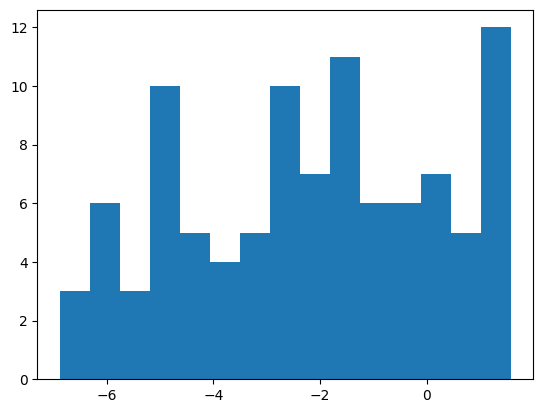

In [36]:
# plot distribution of solubility of generated molecules
plt.hist(np.squeeze(prediction_unbiased), bins=15)

In [69]:
smiles_unbiased

['CCCCCCO',
 'CCCCCCOCSCCCCCC=CCCCCCCO',
 'CO',
 'CCO',
 'CN',
 'C1CC=NCCCOC1=NN=NN',
 'COCN(C1)CCCCNS1C2CCC=NCOC3S(C)CCN=C23',
 'C1CCCCOCCCCCC=CCC(CCCC2CNN1CCC2CCC=CCC)C=NN',
 'CCC=NNSCCCCCC=CCS(C)CCOCN=NCCCCCCCCCCCCCN=CCOS(C)CCCOCN(CCN1NS(C)CO1)CCN=C(C)N=NNS(C)O',
 'C1CCCCCCCCCCN=NN1CCCCOCC=NN',
 'C1CCCCCOP2N1S3(C)COCN23',
 'CN(C)CCCCCN=CCCCCNN',
 'CCCCCCCC1CCNCCN1',
 'N1(CN=CN1COCCC=CNC=CN=CNC)CCCC=C[NH1]CCOCO',
 'O=C1CN=CN=CS(C2)CCNS2OCCCCCC=CNCN1',
 'CCCN',
 'CC#N',
 'CCOSO',
 'CC(C)N',
 'O',
 'C1C=C(C)CC=C(C)CCCC2CCCN1CO2',
 'CCCCN=S(C)N',
 'CCC=C[NH1]NCCCCCO',
 'O=CCCC=CS(C)CCCCCCCOC(C)OCCC1N=C2CC3CCCS2CCC(C)=CC4CCN3CN=NN1CN4',
 'CCCCCCCCCN',
 'C12N=C1N=NN2CCN=NN',
 'C1NNCCOC(C)CCCN=NN1CNO',
 'NCCCCCCC=CN(C)COCCCCCCCCCCOCCC1CCCCN1C=CS(C)O',
 'CCOCCCCCCCOCNN',
 'CCCCCCCCCCCOCCCN=C(C)N=C(C)CCCCCN',
 'C1NN1CCCCCOCCCNCCC2OC(O)=CS2N',
 'CO',
 'O',
 'C1CN=NN=CN1CCCNNS(O)=COCC=CCCCCCCC',
 'CC=CN=S(C)C=CCCOCO',
 'COCN',
 'O=C[NH1]CCC',
 'O=CCCCCCOCCCNC#CCCO',
 'C1COCCCOCCCCCCCC=CCCNN1CC

In [13]:
rewards = []

In [14]:
def run_iters(n_iterations):
  for _ in range(n_iterations):
    rewards.append(policy_gradient(generative_model))
  plt.plot(range(1,len(rewards)+1), rewards)
  plt.xlabel("Iteration Number")
  plt.ylabel("Reward")

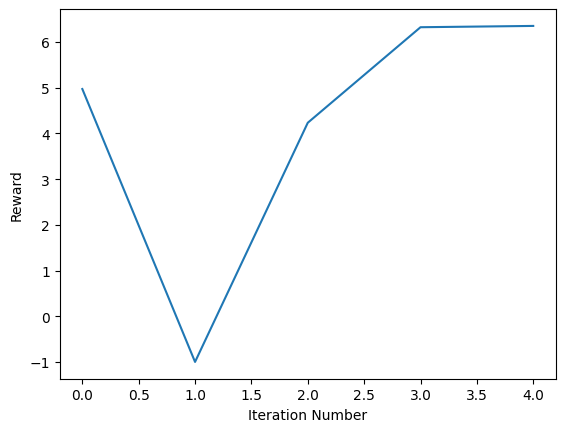

In [63]:
run_iters(5)

In [64]:
# after reinforcement loops
smiles_biased, prediction_biased, invalid_biased = benchmark_predicted_solubility(100)

In [43]:
len(smiles_biased)

100

Text(0, 0.5, 'Count')

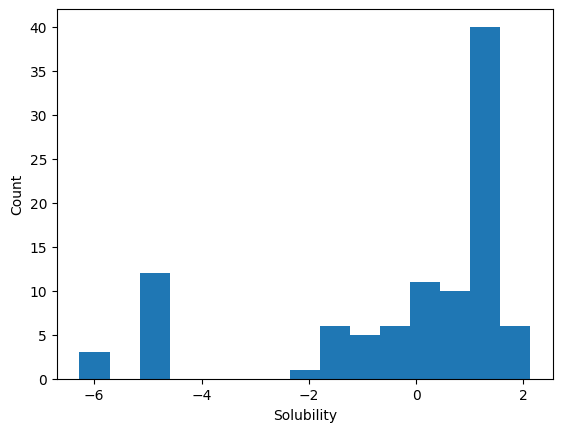

In [76]:
plt.hist(np.squeeze(prediction_biased), bins=15)
plt.xlabel("Solubility")
plt.ylabel("Count")

In [66]:
smiles_biased

['C=N',
 'C1#CCCCN1',
 'CCCO',
 'O',
 'O',
 'C12=CS1CNCC=CS2CNSCO',
 'C=N',
 'O',
 'CF',
 'CO',
 'C1C=CN1',
 'C#1C=CS#1',
 'C=O',
 'COO',
 'CNCC=NO',
 'C#1NP#1',
 'C123CN(NC=CSC1N)CC2NCN3',
 'C1=CSC=CSCN1',
 'C1#CNN1',
 'CO',
 'CO',
 'CNNCO',
 'CO',
 'O',
 'C=N',
 'C1CN1CCO',
 'CCOO',
 'C#N',
 'C1#CCN(C=C1)SCNCF',
 'CO',
 'CCO',
 'C=N',
 'C=N',
 'C=N',
 'O',
 'C#CCO',
 'O',
 'C',
 'O',
 'C(N)C=CSCNCO',
 'C=1=NCS=1CNSNCl',
 'C=N',
 'C=1=CS=1N',
 'COO',
 'COO',
 'CO',
 'C1CCNN1',
 'COCO',
 'C',
 'O',
 'CO',
 'O',
 'C=N',
 'C#C',
 'N',
 'C1CNN1',
 'C#N',
 'CNCN',
 'C=C',
 'NCO',
 'CCO',
 'O',
 'C=N',
 'CN',
 'CNCO',
 'C1NNCN1',
 'C1#CP1COF',
 'C=N',
 'CO',
 'CO',
 'CNCO',
 'O',
 'N',
 'C=N',
 'C1CN1',
 'C#S',
 'C1CNN1',
 'CO',
 'CO',
 'O=O',
 'O',
 'C12=CS1CN2',
 'CNCCN',
 'CO',
 'C1C=SN1',
 'CO',
 'C=1C=C=1',
 'N',
 'COO',
 'C1CN1',
 'C=1=CSCNC=1',
 'CO',
 'C1=2NS1C=2',
 'CO',
 'OCl',
 'C',
 'CO',
 'CCO',
 'C=1=CS=1CN',
 'CO']

In [71]:
top_idxs = np.array(np.squeeze(prediction_biased.numpy())).argsort()

In [72]:
top_idxs

array([48, 37, 95, 49, 80, 61, 51, 38, 36, 34, 23, 71,  3,  4,  7, 86, 17,
       11,  8, 66, 28, 40, 53, 58,  5, 16, 90, 15, 75, 81, 92, 18, 39, 42,
       98, 79, 84, 94, 13, 88, 44, 43, 27, 56, 12,  2, 14, 26, 10, 65, 82,
       25, 35,  1, 57, 46, 47, 97, 30, 60, 21, 55, 76, 59, 77, 91, 78, 96,
       83, 93, 85, 99,  9, 69, 68, 19, 20, 22, 29, 50, 45, 64, 70, 41,  6,
       24, 31, 32,  0, 33, 52, 62, 67, 73, 63, 89, 74, 54, 87, 72])

In [73]:
sorted_smiles_biased = [smiles_biased[idx] for idx in top_idxs]

In [74]:
sorted_smiles_biased

['C',
 'C',
 'C',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'C=1C=C=1',
 'C1=CSC=CSCN1',
 'C#1C=CS#1',
 'CF',
 'C1#CP1COF',
 'C1#CCN(C=C1)SCNCF',
 'C=1=NCS=1CNSNCl',
 'C#C',
 'C=C',
 'C12=CS1CNCC=CS2CNSCO',
 'C123CN(NC=CSC1N)CC2NCN3',
 'C=1=CSCNC=1',
 'C#1NP#1',
 'C#S',
 'C12=CS1CN2',
 'C1=2NS1C=2',
 'C1#CNN1',
 'C(N)C=CSCNCO',
 'C=1=CS=1N',
 'C=1=CS=1CN',
 'O=O',
 'C1C=SN1',
 'OCl',
 'COO',
 'COO',
 'COO',
 'COO',
 'C#N',
 'C#N',
 'C=O',
 'CCCO',
 'CNCC=NO',
 'CCOO',
 'C1C=CN1',
 'C1NNCN1',
 'CNCCN',
 'C1CN1CCO',
 'C#CCO',
 'C1#CCCCN1',
 'CNCN',
 'C1CCNN1',
 'COCO',
 'CCO',
 'CCO',
 'CCO',
 'CNNCO',
 'C1CNN1',
 'C1CNN1',
 'NCO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CNCO',
 'CNCO',
 'C=N',
 'C=N',
 'C=N',
 'C=N',
 'C=N',
 'C=N',
 'C=N',
 'C=N',
 'C=N',
 'C=N',
 'C=N',
 'CN',
 'C1CN1',
 'C1CN1',
 'N',
 'N',
 'N']

In [75]:
predict_solubility(['C1CN1'])

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.7113681]], dtype=float32)>,
 'all valid')

In [70]:
generative_model.save('generative_model_5_RL_iters.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [81]:
# different reward, Reward 2 in written report
smiles_unbiased_2, prediction_unbiased_2, invalid_2 = benchmark_predicted_solubility(100)

Text(0, 0.5, 'Count')

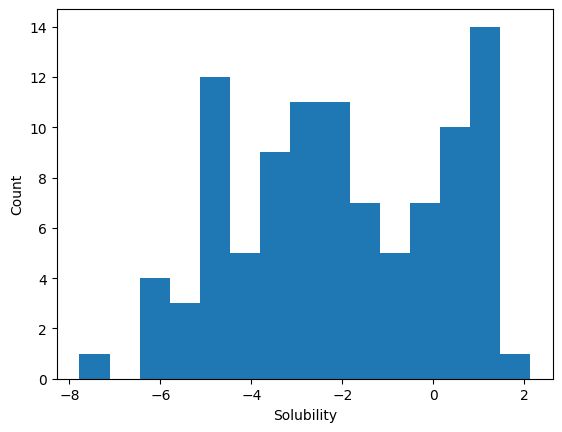

In [84]:
plt.hist(np.squeeze(prediction_unbiased_2), bins=15)
plt.xlabel("Solubility")
plt.ylabel("Count")

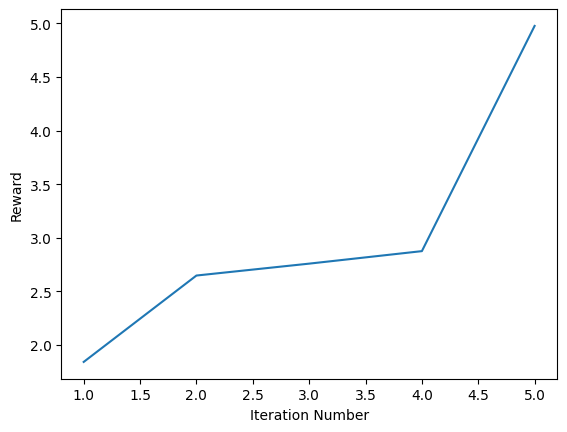

In [98]:
run_iters(5)

In [100]:
smiles_biased_2, prediction_biased_2, invalid_biased_2 = benchmark_predicted_solubility(100)

Text(0, 0.5, 'Count')

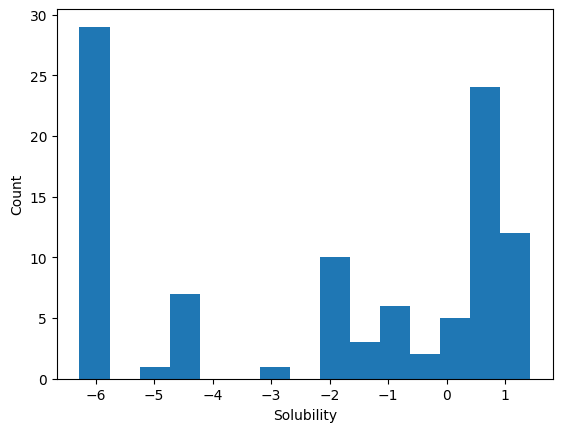

In [101]:
plt.hist(np.squeeze(prediction_biased_2), bins=15)
plt.xlabel("Solubility")
plt.ylabel("Count")

In [102]:
top_idxs_2 = np.array(np.squeeze(prediction_biased_2.numpy())).argsort()

In [103]:
sorted_smiles_biased_2 = [smiles_biased_2[idx] for idx in top_idxs_2]

In [104]:
sorted_smiles_biased_2

['C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'F',
 'F',
 'Br',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'CC',
 'CF',
 'CF',
 'CF',
 'CF',
 'CF',
 'CF',
 'CF',
 'CF',
 'CF',
 'CF',
 'C=CSCF',
 'C1#CC1[NH1]N=CCCF',
 'CCl',
 'CCF',
 'CCF',
 'CBr',
 'CBr',
 'CBr',
 'C=P=CC#N',
 'C#S',
 'C=NNNF',
 'C=1=C[NH1]N=1',
 'CCC#N',
 'OCl',
 'C1=NNN1',
 'C=1(CN=1)O',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'NCl',
 'NCl',
 'C=O',
 'C=O',
 'C=O',
 'C=O',
 'OBr',
 'C=C[NH1]CF',
 'C=NO',
 'OP',
 'NBr',
 'C=1[NH1]N=1',
 'CNBr',
 'C[NH1]O',
 'C=CNF',
 'C[NH1]CF',
 'C=CO',
 'CCO',
 'CCO',
 'C1[NH1]N1',
 'CNF',
 'CNF',
 'CNF',
 'CNF',
 'OC',
 'CO',
 'C[NH1]C']

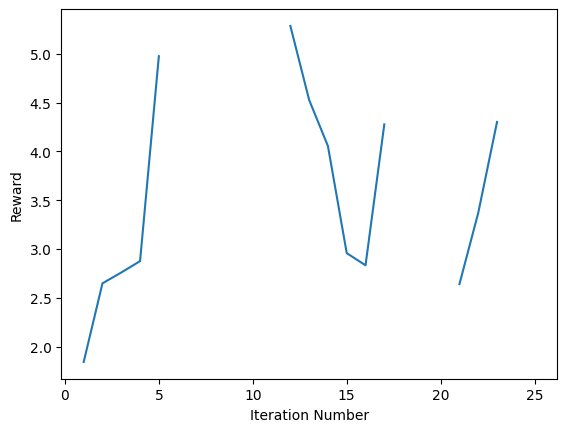

In [107]:
run_iters(5)

In [108]:
smiles_biased_3, prediction_biased_3, invalid_biased_3 = benchmark_predicted_solubility(100)

Text(0, 0.5, 'Count')

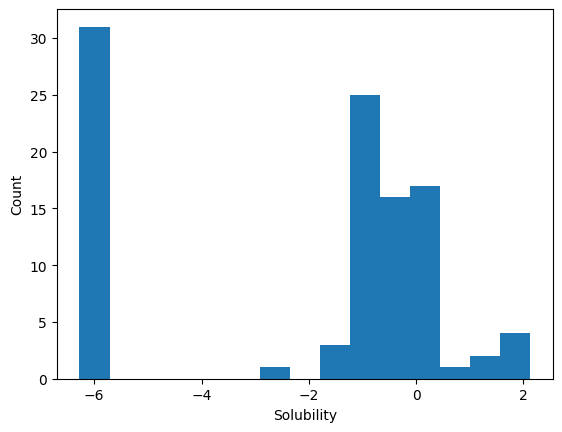

In [109]:
plt.hist(np.squeeze(prediction_biased_3), bins=15)
plt.xlabel("Solubility")
plt.ylabel("Count")

In [ ]:
# all "None" rewards are insoluble molecules

In [110]:
rewards

[1.8433232307434082,
 2.648832678794861,
 2.7597979307174683,
 2.8763517141342163,
 4.97633695602417,
 None,
 4.286500185728073,
 None,
 None,
 None,
 None,
 5.286503314971924,
 4.527799129486084,
 4.055171579122543,
 2.958439588546753,
 2.8333938121795654,
 4.2775019109249115,
 None,
 2.8333938121795654,
 None,
 2.641049385070801,
 3.3709205389022827,
 4.302522927522659,
 None,
 4.582914710044861]

In [ ]:
# Test adding to existing molecule (MMLI top performer)

In [10]:
smiles_unbiased_3, prediction_unbiased_3, invalid_3 = benchmark_predicted_solubility(100)

[15:45:55] Explicit valence for atom # 26 C, 5, is greater than permitted
[15:45:55] Explicit valence for atom # 26 O, 3, is greater than permitted
[15:45:55] Explicit valence for atom # 26 O, 3, is greater than permitted
[15:45:55] Explicit valence for atom # 26 O, 3, is greater than permitted
[15:45:55] Explicit valence for atom # 26 O, 3, is greater than permitted
[15:45:55] Explicit valence for atom # 26 O, 3, is greater than permitted
[15:45:56] Explicit valence for atom # 26 O, 3, is greater than permitted
[15:45:56] Explicit valence for atom # 26 O, 3, is greater than permitted
[15:45:57] Explicit valence for atom # 26 O, 3, is greater than permitted
[15:45:57] Explicit valence for atom # 26 O, 3, is greater than permitted
[15:45:57] Explicit valence for atom # 26 C, 5, is greater than permitted
[15:45:57] Explicit valence for atom # 26 C, 5, is greater than permitted
[15:45:57] Explicit valence for atom # 26 O, 3, is greater than permitted
[15:45:58] Explicit valence for atom #

Text(0, 0.5, 'Count')

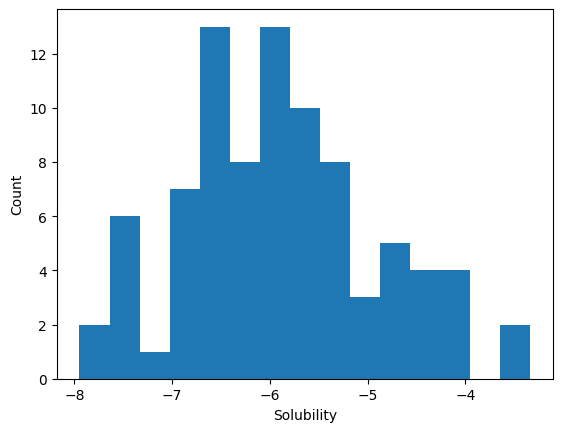

In [11]:
plt.hist(np.squeeze(prediction_unbiased_3), bins=15)
plt.xlabel("Solubility")
plt.ylabel("Count")

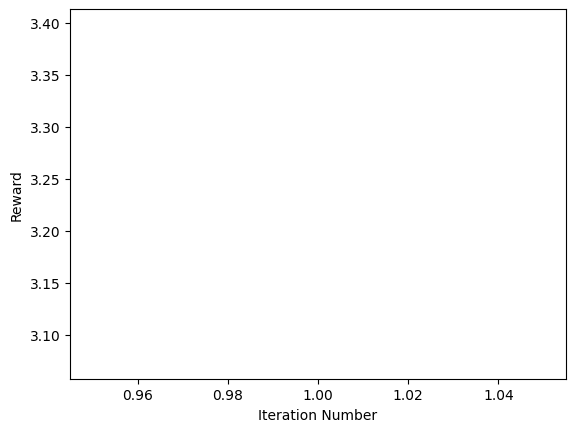

In [15]:
run_iters(1)

In [16]:
rewards

[3.235414981842041]

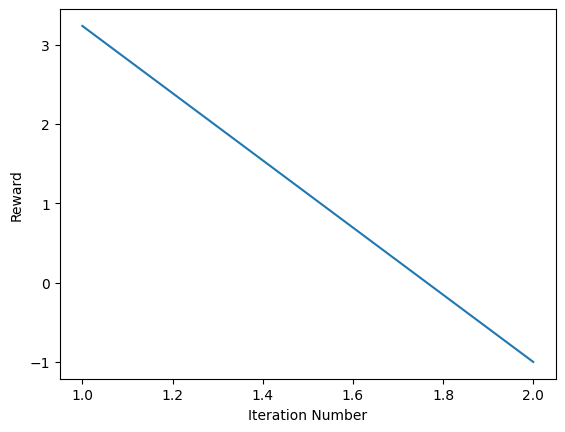

In [17]:
run_iters(1)

[15:47:28] Explicit valence for atom # 26 C, 5, is greater than permitted


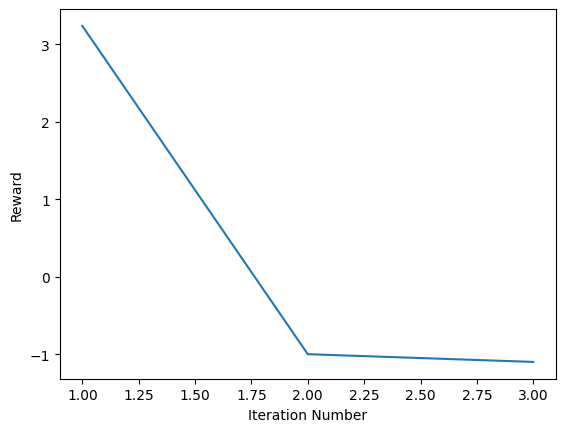

In [18]:
run_iters(1)

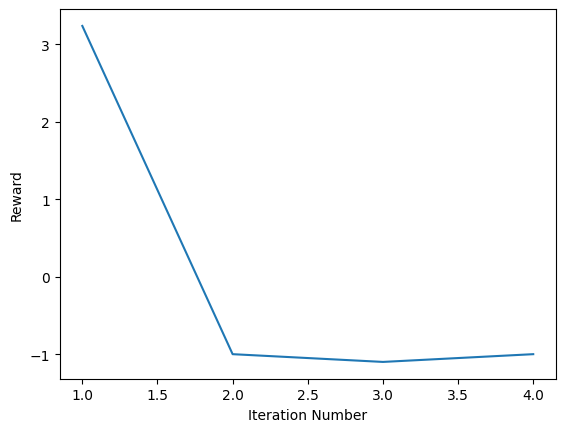

In [19]:
run_iters(1)

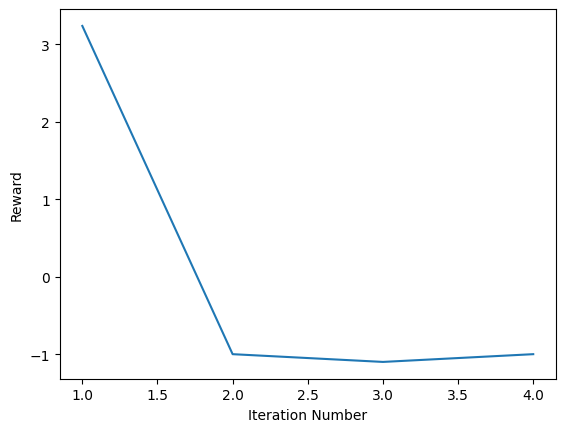

In [20]:
run_iters(1)

In [21]:
smiles_biased_4, prediction_biased_4, invalid_4 = benchmark_predicted_solubility(100)

[16:31:31] Explicit valence for atom # 26 C, 5, is greater than permitted
[16:31:32] Explicit valence for atom # 26 C, 5, is greater than permitted
[16:31:32] Explicit valence for atom # 26 C, 5, is greater than permitted
[16:31:32] Explicit valence for atom # 26 C, 5, is greater than permitted
[16:31:32] Explicit valence for atom # 26 C, 5, is greater than permitted
[16:31:32] Explicit valence for atom # 26 C, 5, is greater than permitted
[16:31:32] Explicit valence for atom # 26 O, 3, is greater than permitted
[16:31:32] Explicit valence for atom # 26 C, 5, is greater than permitted
[16:31:32] Explicit valence for atom # 26 C, 5, is greater than permitted
[16:31:32] Explicit valence for atom # 26 C, 5, is greater than permitted
[16:31:32] Explicit valence for atom # 26 C, 5, is greater than permitted
[16:31:32] Explicit valence for atom # 26 C, 5, is greater than permitted
[16:31:32] Explicit valence for atom # 26 C, 5, is greater than permitted
[16:31:32] Explicit valence for atom #

In [22]:
len(smiles_biased_4)

79

Text(0, 0.5, 'Count')

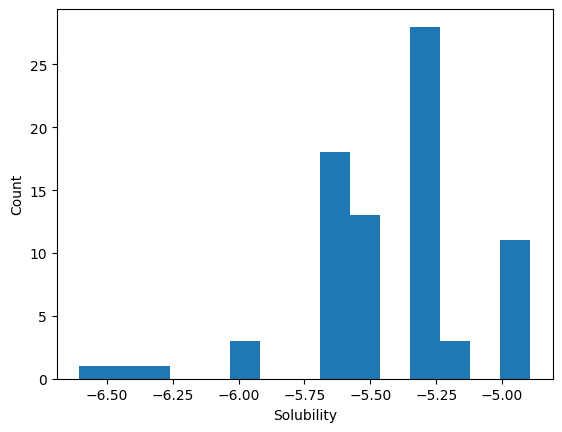

In [24]:
plt.hist(np.squeeze(prediction_biased_4), bins=15)
plt.xlabel("Solubility")
plt.ylabel("Count")

In [25]:
smiles_biased_4

['N',
 'CO',
 'C=1CN=1',
 'C=O',
 'C#N',
 'C=NO',
 'O',
 'C#N',
 'C=O',
 'CO',
 'Br',
 'C#N',
 'C#N',
 'CO',
 'C(C)=O',
 'C=O',
 'C',
 'C',
 'CO',
 'C#N',
 'C',
 'CO',
 'C',
 'O',
 'C=O',
 'CO',
 'C',
 'F',
 'N',
 'C#N',
 'CO',
 'C#N',
 'O',
 'C#N',
 'C',
 'C',
 'O',
 'CO',
 'C#N',
 'C',
 'CO',
 'CO',
 'CO',
 'CO',
 'F',
 'CO',
 'C#N',
 'C#C',
 'O',
 'C#N',
 'CF',
 'O',
 'C#N',
 'CO',
 'O',
 'O',
 'C#N',
 'CO',
 'CO',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C',
 'C#N',
 'O',
 'C#N',
 'C#N',
 'C',
 'C#N',
 'C#N',
 'CO',
 'O',
 'N',
 'CO',
 'O',
 'O',
 'C#N',
 'O']

In [30]:
top_idxs_4 = np.array(np.squeeze(prediction_biased_4.numpy())).argsort()

In [31]:
sorted_smiles_biased_4 = [smiles_biased_4[idx] for idx in top_idxs_4]

In [34]:
prediction_biased_4

<tf.Tensor: shape=(79, 1), dtype=float32, numpy=
array([[-5.971916 ],
       [-5.6476316],
       [-6.6034036],
       [-5.3159285],
       [-5.2681212],
       [-6.3927283],
       [-5.553322 ],
       [-5.2681212],
       [-5.3159285],
       [-5.6476316],
       [-4.9100647],
       [-5.2681212],
       [-5.2681212],
       [-5.6476316],
       [-5.33013  ],
       [-5.3159285],
       [-4.8929553],
       [-4.8929553],
       [-5.6476316],
       [-5.2681212],
       [-4.8929553],
       [-5.6476316],
       [-4.8929553],
       [-5.553322 ],
       [-5.3159285],
       [-5.6476316],
       [-4.8929553],
       [-5.1742177],
       [-5.971916 ],
       [-5.2681212],
       [-5.6476316],
       [-5.2681212],
       [-5.553322 ],
       [-5.2681212],
       [-4.8929553],
       [-4.8929553],
       [-5.553322 ],
       [-5.6476316],
       [-5.2681212],
       [-4.8929553],
       [-5.6476316],
       [-5.6476316],
       [-5.6476316],
       [-5.6476316],
       [-5.1742177],
      

In [35]:
top_idxs_4

array([ 2,  5, 47, 28, 73,  0, 41, 45, 21, 43, 53, 18, 37,  1, 57, 13, 25,
       71, 30,  9, 40, 74, 58, 42, 32, 54, 48, 51, 55, 65, 72,  6, 75, 76,
       23, 36, 78, 14, 15,  3, 24,  8, 77, 66, 12, 64, 70, 62, 61, 60, 59,
       11, 56, 52, 67,  7, 49,  4, 46, 29, 31, 33, 38, 19, 69, 50, 44, 27,
       10, 34, 63, 35, 16, 17, 20, 22, 26, 68, 39])

In [33]:
sorted_smiles_biased_4

['C=1CN=1',
 'C=NO',
 'C#C',
 'N',
 'N',
 'N',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'CO',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'C(C)=O',
 'C=O',
 'C=O',
 'C=O',
 'C=O',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'C#N',
 'CF',
 'F',
 'F',
 'Br',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C']